<a href="https://colab.research.google.com/github/jqshang/CSC2541/blob/main/Experiments/grangernn_causal_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jqshang/CSC2541.git
%cd CSC2541

Cloning into 'CSC2541'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 175 (delta 63), reused 122 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (175/175), 2.96 MiB | 28.83 MiB/s, done.
Resolving deltas: 100% (63/63), done.
/content/CSC2541


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset.syn_data import generate_synthetic_protein_data
from model.granger_nn import GrangerNeuralNet
from model.util import adjacency_to_digraph, plot_digraph, combine_position_angle_scores, print_sccs
from model.graph import filter_paths, build_scc_quotient_graph
from train_granger_nn import train_granger_net

In [3]:
pairs = [("A1", "A16"), ("A16", "A17"), ("A17", "A30"), ("A30", "A36"), ("A30", "A16"), ("A36", "A50")]
num_acids = 50
num_steps = 200
positions, angles, amino_acids = generate_synthetic_protein_data(num_acids, num_steps, pairs)

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 50/300 | MSE: 0.0226 | L1_v: 21.3978 | L1_t: 106.9878
Epoch 100/300 | MSE: 0.0101 | L1_v: 20.2735 | L1_t: 101.3635
Epoch 150/300 | MSE: 0.0054 | L1_v: 19.1489 | L1_t: 95.7389
Epoch 200/300 | MSE: 0.0031 | L1_v: 18.0241 | L1_t: 90.1142
Epoch 250/300 | MSE: 0.0019 | L1_v: 16.8992 | L1_t: 84.4893
Epoch 300/300 | MSE: 0.0013 | L1_v: 15.7743 | L1_t: 78.8645


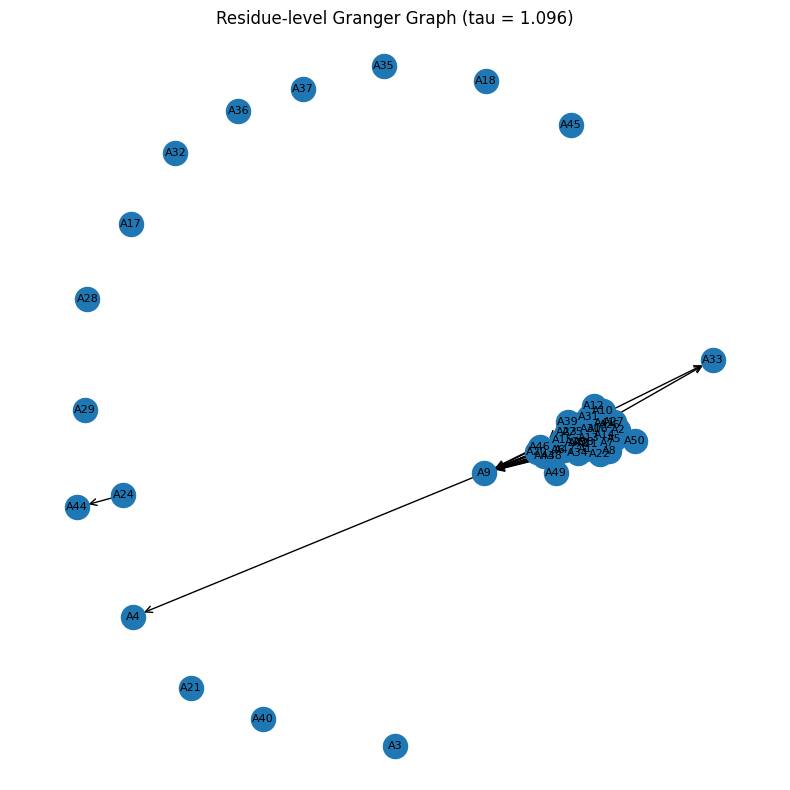

In [6]:
G_res_position, tau_position, S_res_position = train_granger_net(positions, n_epochs=300)
DG_res_position = adjacency_to_digraph(G_res_position,node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_position:.3f})"
plot_digraph(DG_res_position, node_names=amino_acids, title=plot_title)

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 50/300 | MSE: 0.0247 | L1_v: 9.5099 | L1_t: 47.5498
Epoch 100/300 | MSE: 0.0091 | L1_v: 9.0102 | L1_t: 45.0501
Epoch 150/300 | MSE: 0.0047 | L1_v: 8.5104 | L1_t: 42.5502
Epoch 200/300 | MSE: 0.0027 | L1_v: 8.0104 | L1_t: 40.0502
Epoch 250/300 | MSE: 0.0017 | L1_v: 7.5104 | L1_t: 37.5502
Epoch 300/300 | MSE: 0.0012 | L1_v: 7.0103 | L1_t: 35.0501


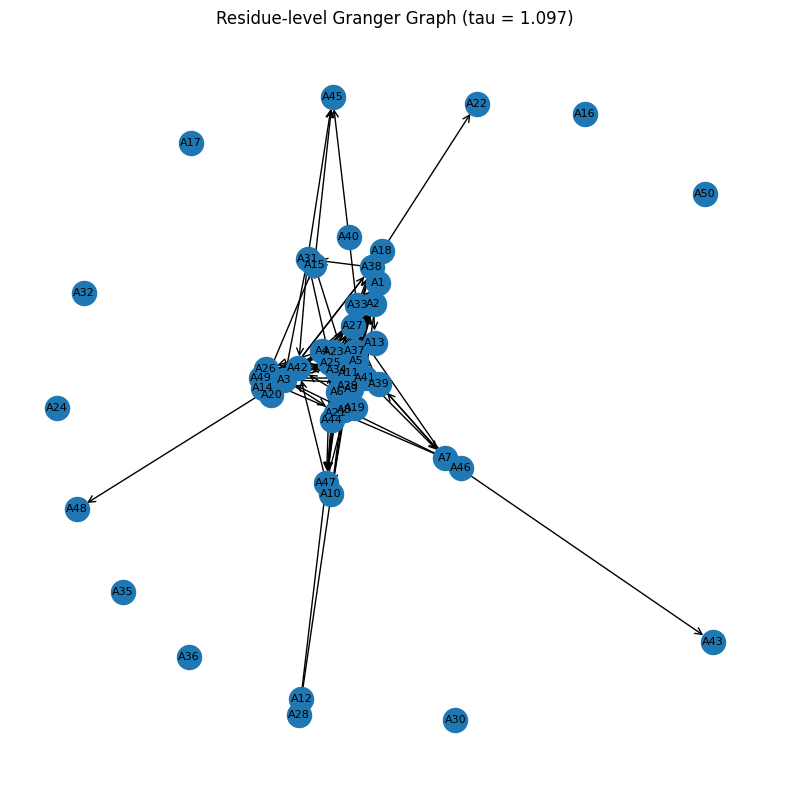

In [7]:
G_res_angle, tau_angle, S_res_angle = train_granger_net(angles, n_epochs=300)
DG_res_angle = adjacency_to_digraph(G_res_angle, node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_angle:.3f})"
plot_digraph(DG_res_angle, node_names=amino_acids, title=plot_title)

Combined threshold (tau_comb): 0.9992276
Number of residue edges in combined graph: 125


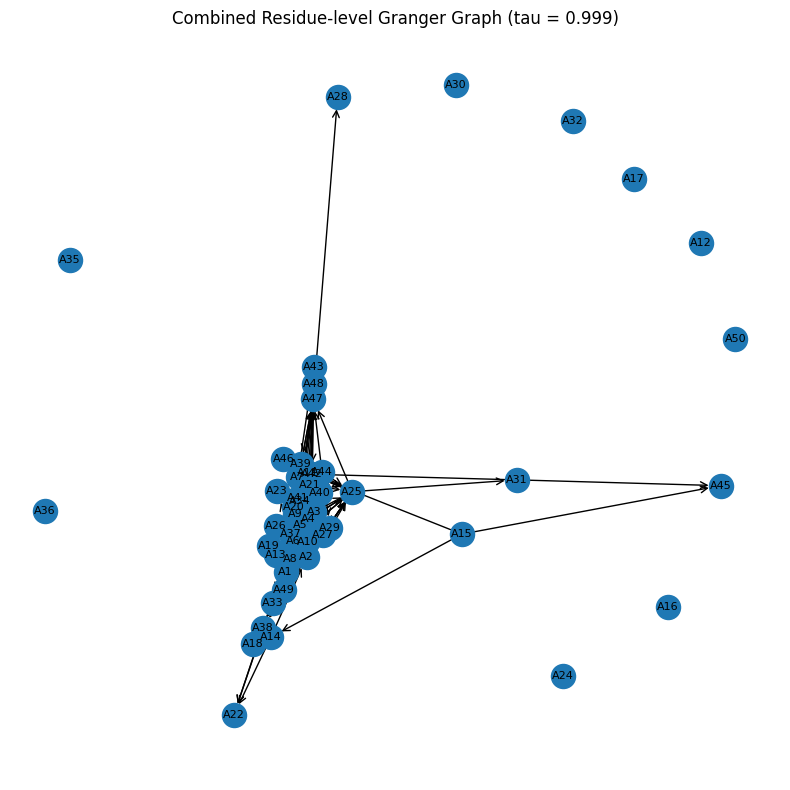

In [11]:
G_res_comb, tau_comb, S_res_comb = combine_position_angle_scores(S_res_position, S_res_angle)
print("Combined threshold (tau_comb):", tau_comb)
print("Number of residue edges in combined graph:", G_res_comb.sum())

DG_res_comb = adjacency_to_digraph(G_res_comb, node_names=amino_acids)
plot_title = f"Combined Residue-level Granger Graph (tau = {tau_comb:.3f})"
plot_digraph(DG_res_comb, node_names=amino_acids, title=plot_title)

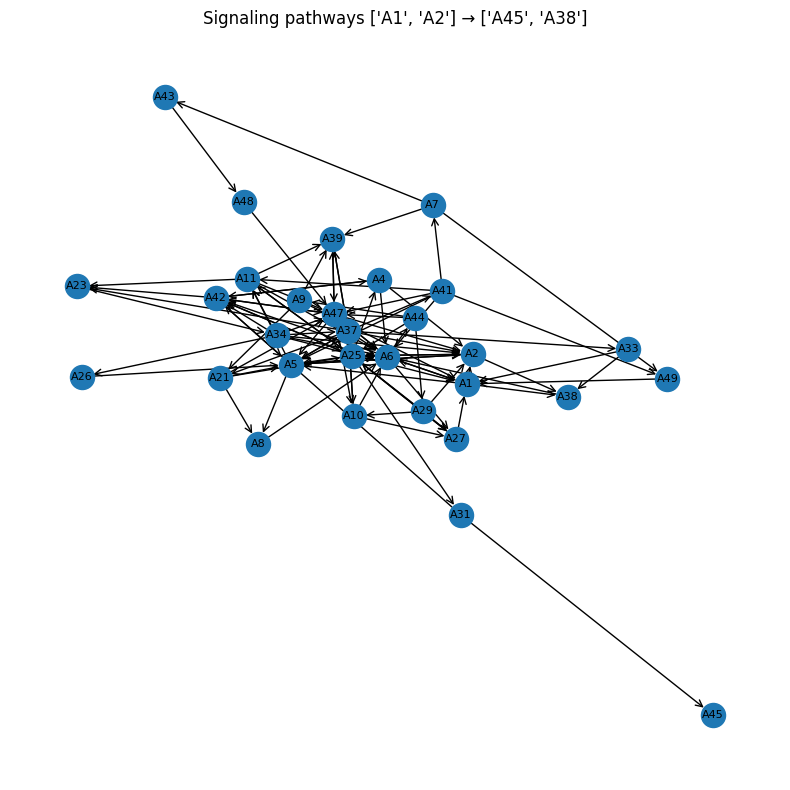

In [26]:
# assuming plot_digraph(DG, node_names, title) is already defined

allosteric_sites = ["A1", "A2"]
active_sites = ["A45", "A38"]

paths_by_source, DG_signal = filter_paths(
    DG_res_comb,
    amino_acids,
    allosteric_sites,
    active_sites
)

plot_title = f"Signaling pathways {allosteric_sites} → {active_sites}"
plot_digraph(DG_signal, node_names=amino_acids, title=plot_title)

Strongly connected components (SCCs):
  SCC 0: A45
  SCC 1: A1, A2, A4, A5, A6, A7, A8, A9, A10, A11, A21, A23, A25, A26, A27, A29, A31, A33, A34, A37, A38, A39, A41, A42, A43, A44, A47, A48, A49


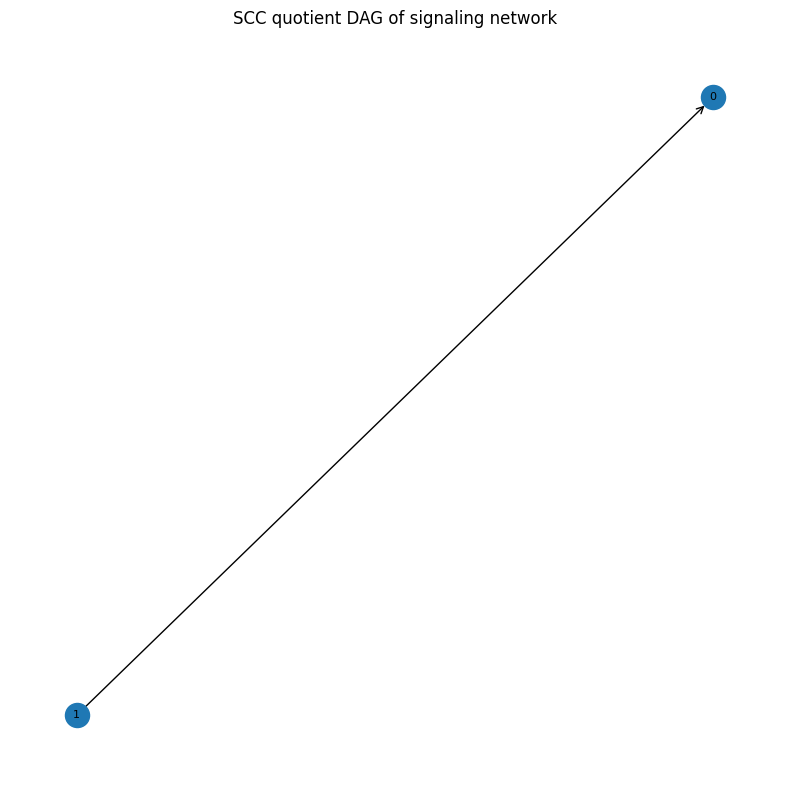

In [28]:
sccs, node_to_scc, Q = build_scc_quotient_graph(DG_signal, amino_acids)

print_sccs(sccs, amino_acids)

plot_title = "SCC quotient DAG of signaling network"
plot_digraph(Q, title=plot_title)